In [89]:
import numpy as np
import IPython.display as ipd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import warnings
import librosa
import librosa.display
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
warnings.filterwarnings('ignore')

# Load Data

In [2]:
X_train = np.load("xtrain_spec.npy")
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
train = np.load("train.npy")
y_train = train[:,0]
X_labeled = X_train[y_train != -1]
y_labeled = y_train[y_train != -1]
X_unlabeled = X_train[y_train == -1]
y_unlabeled = y_train[y_train == -1]

X_test = np.load("test_spec.npy")
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

# PCA

In [3]:
pca = PCA(n_components=1000)
pca.fit(X_train)
print(pca.explained_variance_ratio_)

[4.30495258e-01 1.79914217e-01 4.78489892e-02 1.77153116e-02
 1.20099768e-02 8.73604241e-03 6.31408684e-03 4.74506220e-03
 3.71045227e-03 3.69787215e-03 3.31058764e-03 2.93725779e-03
 2.90685819e-03 2.77334528e-03 2.65100388e-03 2.59386489e-03
 2.36487028e-03 2.27360210e-03 2.24294083e-03 2.18420959e-03
 2.10785740e-03 1.83049703e-03 1.79823932e-03 1.75391243e-03
 1.65178847e-03 1.55101301e-03 1.53489716e-03 1.40352704e-03
 1.38571100e-03 1.37011354e-03 1.32496170e-03 1.22455666e-03
 1.19328342e-03 1.16949502e-03 1.11178571e-03 1.07210301e-03
 1.05171608e-03 1.03683874e-03 1.02785348e-03 9.80506909e-04
 9.73421408e-04 9.56251191e-04 9.52760485e-04 9.27533850e-04
 9.04431709e-04 8.96494062e-04 8.63974186e-04 8.39207702e-04
 8.24994368e-04 8.08207987e-04 7.89340845e-04 7.57462262e-04
 7.34917532e-04 7.15342055e-04 6.92358995e-04 6.89872948e-04
 6.84436247e-04 6.65864256e-04 6.52428789e-04 6.34015945e-04
 6.30110592e-04 6.19152421e-04 6.10152401e-04 5.97908866e-04
 5.92344402e-04 5.862583

In [4]:
cum = [pca.explained_variance_ratio_[0]]
for i in range(1, len(pca.explained_variance_ratio_)):
    cum.append(cum[-1] + pca.explained_variance_ratio_[i])

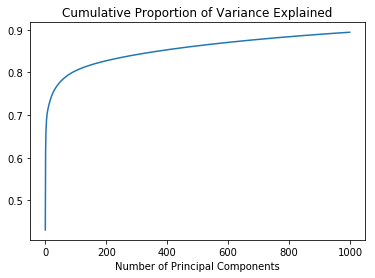

In [5]:
plt.title("Cumulative Proportion of Variance Explained")
plt.xlabel("Number of Principal Components")
plt.plot(cum)

# Random Forest Classification

In [79]:
X_dimred = pca.transform(X_train)
X_labeled = X_dimred[y_train != -1]
y_labeled = y_train[y_train != -1]
X_unlabeled = X_dimred[y_train == -1]
y_unlabeled = y_train[y_train == -1]
means = [np.mean(X_dimred[y_train == k],axis=0) for k in range(10)]
for i in range(len(X_unlabeled)):
    y_unlabeled[i] = np.argmin([np.linalg.norm(X_unlabeled[i] - means[k]) for k in range(10)])
y_unlabeled[:10]
clf_xgb = XGBClassifier()
clf_xgb.fit(np.concatenate((X_labeled,X_unlabeled), axis=0), np.concatenate((y_labeled,y_unlabeled), axis=0))
predictions = clf_xgb.predict(pca.transform(X_test))

In [90]:
print("XGB_score: %f" % accuracy_score(clf_xgb.predict(X_labeled), y_labeled))

XGB_score: 0.669701


# Write Predictions

In [10]:
with open("predictions_xg.csv", "w") as f:
    f.write("Id,Prediction\n")
    for i, u in enumerate(predictions):
        f.write(str(i) + "," + str(int(u)) + "\n")

In [93]:
from sklearn.linear_model import LogisticRegression
clf_log = LogisticRegression()
clf_log.fit(np.concatenate((X_labeled,X_unlabeled), axis=0), np.concatenate((y_labeled,y_unlabeled), axis=0))
predictions_log = clf_log.predict(pca.transform(X_test))

In [98]:
print("LOG_score: %f" % accuracy_score(clf_log.predict(X_labeled), y_labeled))

LOG_score: 0.725184


In [100]:
clf_mlp = MLPClassifier()
clf_mlp.fit(np.concatenate((X_labeled,X_unlabeled), axis=0), np.concatenate((y_labeled,y_unlabeled), axis=0))
print("MLP score: %f" % accuracy_score(clf_mlp.predict(X_labeled), y_labeled))

MLP score: 1.000000


In [104]:
clf_rf = RandomForestClassifier()
clf_rf.fit(np.concatenate((X_labeled,X_unlabeled), axis=0), np.concatenate((y_labeled,y_unlabeled), axis=0))
print("RF_score: %f" % accuracy_score(clf_rf.predict(X_labeled), y_labeled))

RF_score: 0.995665


In [103]:
clf_rf_0 = RandomForestClassifier()
clf_rf_0.fit(X_labeled, y_labeled)
print("RF just labelled score: %f" % accuracy_score(clf_rf_0.predict(X_labeled), y_labeled))

RF just labelled score: 0.994798


In [107]:
X_labeled = X_train[y_train != -1]
y_labeled = y_train[y_train != -1]
X_unlabeled = X_train[y_train == -1]
y_unlabeled = y_train[y_train == -1]
means = [np.mean(X_train[y_train == k],axis=0) for k in range(10)]
for i in range(len(X_unlabeled)):
    y_unlabeled[i] = np.argmin([np.linalg.norm(X_unlabeled[i] - means[k]) for k in range(10)])

In [ ]:
clf_rf_1 = RandomForestClassifier()
clf_rf_1.fit(np.concatenate((X_labeled,X_unlabeled), axis=0), np.concatenate((y_labeled,y_unlabeled), axis=0))
print("RF_1_score: %f" % accuracy_score(clf_rf.predict(X_labeled), y_labeled))

In [113]:
X_train = train[:,1:]
y_train = train[:,0]
pca_basic = PCA(n_components=1000)
pca_basic.fit(X_train)
X_train = pca_basic.transform(X_train)
X_labeled = X_train[y_train != -1]
y_labeled = y_train[y_train != -1]
X_unlabeled = X_train[y_train == -1]
y_unlabeled = y_train[y_train == -1]

means = [np.mean(X_train[y_train == k],axis=0) for k in range(10)]
for i in range(len(X_unlabeled)):
    y_unlabeled[i] = np.argmin([np.linalg.norm(X_unlabeled[i] - means[k]) for k in range(10)])

In [ ]:
clf_rf_2 = RandomForestClassifier()
clf_rf_2.fit(np.concatenate((X_labeled,X_unlabeled), axis=0), np.concatenate((y_labeled,y_unlabeled), axis=0))
print("RF_2_score: %f" % accuracy_score(clf_rf.predict(pca_basic.transform(X_labeled)), y_labeled))

# Write Predictions

In [15]:
with open("predictions_mlp.csv", "w") as f:
    f.write("Id,Prediction\n")
    for i, u in enumerate(predictions_mlp):
        f.write(str(i) + "," + str(int(u)) + "\n")

# Listening to the audio
This code enables you to listen to a sample sine wave audio.

In [31]:
SAMPLE_RATE = 22050
train = np.load("train.npy")
train = train[:,1:]
y_train = train[:,0]
y_labeled_labels = y_train[y_train != -1] 

In [36]:
y_unlabled_labels

[4,
 3,
 9,
 5,
 4,
 3,
 2,
 3,
 9,
 5,
 3,
 4,
 0,
 4,
 4,
 1,
 10,
 9,
 10,
 9,
 3,
 5,
 9,
 6,
 5,
 0,
 0,
 5,
 8,
 0,
 2,
 2,
 2,
 2,
 7,
 4,
 0,
 0,
 9,
 4,
 3,
 1,
 4,
 9,
 3,
 9,
 2,
 7,
 9,
 4,
 7,
 2,
 2,
 8,
 7,
 3,
 3,
 3,
 2,
 5,
 4,
 0,
 9,
 9,
 0,
 7,
 2,
 0,
 9,
 1,
 0,
 5,
 9,
 9,
 9,
 4,
 5,
 3,
 9,
 0,
 2,
 2,
 0,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 

In [77]:
hist = [sum(predictions_log == i)/len(predictions_log) for i in range(10)]
real_hist = [sum(y_labeled == i)/len(y_labeled) for i in range(10)]

Text(0, 0.5, 'Frequency')

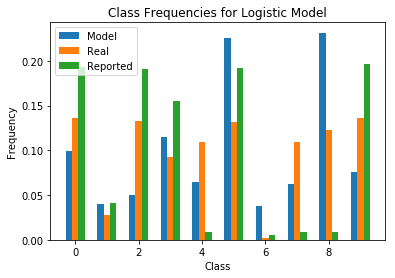

In [78]:
w=0.2
plt.bar(np.array(range(10))-[w] * 10, hist, w)
plt.bar(np.array(range(10)), hist_freq, w)
plt.bar(np.array(range(10))+[w] * 10, real_hist, w)
plt.title("Class Frequencies for Logistic Model")
plt.legend(['Model', 'Real', 'Reported'])
plt.xlabel('Class')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

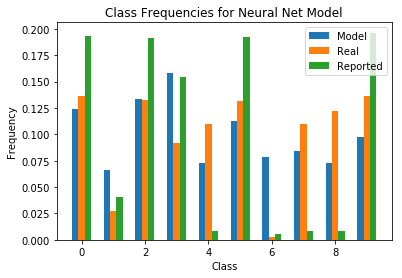

In [73]:
hist_mlp = [sum(predictions_mlp == i)/len(predictions_mlp) for i in range(10)]
real_hist = [sum(y_labeled == i)/len(y_labeled) for i in range(10)]
w=0.2
plt.bar(np.array(range(10))-[w] * 10, hist_mlp, w)
plt.bar(np.array(range(10)), hist_freq, w)
plt.bar(np.array(range(10))+[w] * 10, real_hist, w)
plt.title("Class Frequencies for Neural Net Model")
plt.legend(['Model', 'Real', 'Reported'])
plt.xlabel('Class')
plt.ylabel('Frequency')

In [56]:
np.array(hist_mlp) - np.array(real_hist)

array([-0.06924475,  0.0255005 , -0.05761371,  0.00298228,  0.06388594,
       -0.07994459,  0.07366279,  0.07545271,  0.06388594, -0.09856711])

In [68]:
hist_freq = np.array([13.61,2.77,13.23,9.22,10.98,13.12,0.22,10.96,12.24,13.65])/100